In [239]:
import pickle
import matplotlib.pyplot as plt
from ctypes import *
import numpy as np
import base64

In [240]:
from lib.proto.protocol_pb2 import *
from google.protobuf.json_format import MessageToJson, ParseDict, MessageToDict
from lib.proto.protocol_pb2 import DatumTypeID, LinkID, TalkerID
import lib.proto.protocol_pb2 as protocol
from lib.comms_lib.crctabgen import crc16
# from link import cobs_decode

In [241]:
segments = pickle.load(open("./log_200hz.pickle", 'rb'))
segments, ack = segments[:-1], segments[-1]
crc_xor = ack['log_crc16']

In [242]:
print(segments[0].keys())

dict_keys(['start_address', 'length', 'data', 'segment_crc16'])


In [243]:
xor = 0
for s in segments:
    xor ^= s['segment_crc16']
if (xor == crc_xor):
    print("Data valid!")

Data valid!


In [244]:
LOGGER_COBS_ESC =0xAA
LOGGER_COBS_ESC_AA =0x01
LOGGER_COBS_ESC_FF =0x02
def cobs_decode(data: bytes) -> bytes:
    dout = bytes()
    diter = iter(data)
    while (d := next(diter, None)) is not None:
        if (d == LOGGER_COBS_ESC):
            dout += bytes([LOGGER_COBS_ESC if next(diter, None)
                          == LOGGER_COBS_ESC_AA else 0xFF])
        else:
            dout += bytes([d])
    return dout

In [245]:
# TODO: Change the escape byte!!! 00 is too common...
databuffer = bytes()
for s in segments:
    databuffer += base64.b64decode(s['data'])
# data = cobs_decode(databuffer)
print(len(data), len(databuffer))

216594 57847


In [246]:
frames = databuffer.split(b'\xFF')
frames_dec = [cobs_decode(f) for f in frames if len(f)]
print({len(f) for f in frames_dec})
assert len({len(f) for f in frames_dec}) == 1

{80}


In [247]:
# typedef struct log_data_t {
#     // Sensor data
#     uint32_t lps_press_raw;
#     uint16_t lis_mag_raw[3];
#     uint16_t lsm_acc_raw[3];
#     uint16_t lsm_gyr_raw[3];
#     float adxl_acc_raw[3]; // TYPE TBD!!!
#     // Processed data
#     float orientation_quat[4];
#     float filtered_altitude_m;
#     // From GPS
#     float gps_lat;
#     float gps_lon;
#     float gps_alt;
#     uint8_t flags;
# } log_data_t;

class LogDataT(Structure):
    _fields_ = [
        ("TIMESTAMP", c_uint64),
        ("lps_press_raw", c_uint32),
        ("lis_mag_raw", c_int16*3),
        ("lsm_acc_raw", c_int16*3),
        ("lsm_gyr_raw", c_int16*3),
        ("adxl_acc_raw", c_float*3),
        ("orientation_quat", c_float*4),
        ("filtered_altitude_m", c_float),
        ("gps_lat", c_float),
        ("gps_lon", c_float),
        ("gps_alt", c_float),
        ("flags", c_uint8),
    ]
    
assert (sizeof(LogDataT)) == len(frames_dec[0])

In [248]:
parsed_frames = [LogDataT.from_buffer_copy(b) for b in frames_dec]

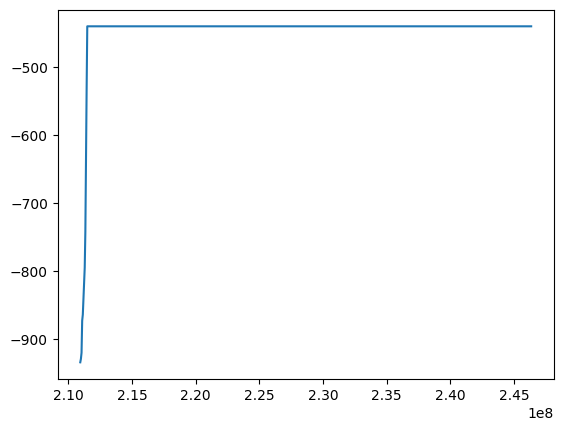

In [255]:
def magnetometer_cal():
    times = [f.TIMESTAMP for f in parsed_frames]
    mag_xs = [f.lis_mag_raw[0] for f in parsed_frames]
    mag_ys = [f.lis_mag_raw[1] for f in parsed_frames]
    mag_zs = [f.lis_mag_raw[2] for f in parsed_frames]
    # print(times)
    
    plt.plot(times, mag_zs)
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    # ax.scatter(mag_xs, mag_ys, mag_zs)

    # ax.set_xlabel('Magnetometer X (raw)')
    # ax.set_ylabel('Magnetometer Y (raw)')
    # ax.set_zlabel('Magnetometer Z (raw)')
magnetometer_cal()